## **Data preprocessing and exploring**

### Access Files in Drive

---

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import required libraries and necessary packages**

In [20]:
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import time


import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

# **Load The data**

In [21]:
#The path of our data on drive
data_dir =  r'/content/drive/My Drive/Three Skin Datasets'
 
 
#Loading Data
data = load_files(data_dir)

In [22]:
folders=os.listdir("/content/drive/My Drive/Three Skin Datasets")
print(folders)

['Lesion', 'Psoriasis', 'Melanoma']


In [23]:
#Convert the data and labels to Numpy arrays
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])
 
# How the arrays look like?
print('Data files - ',X[0])
print('Target labels - ',y[0])
print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Data files -  /content/drive/My Drive/Three Skin Datasets/Psoriasis/08lichenPlanusTongue1122051.jpg
Target labels -  2
Number of training files :  300
Number of training targets :  300


# **Some Images preprocessing**

In [24]:
def convert_img_to_arr(file_path_list):
    arr = []
    img_width, img_height = 150,150 
    # Loop over the image paths
    for file_path in file_path_list:
        """
           Load the image, swap color channels, and resize it to be a fixed
           150*150 pixels while ignoring aspect ratio
        """
        img = load_img(file_path, target_size = (img_width, img_height))
        img=np.uint8(img)
        img = cv2.fastNlMeansDenoisingColored(img)
        
        # update the data
        arr.append(img)
    return arr
# Here our data is updated and it's stocked in the X array again !
X = np.array(convert_img_to_arr(X))
 
# The Data Shape
print(X.shape) 
print('First training item : ',X[0])

(300, 150, 150, 3)
First training item :  [[[122  84  71]
  [122  84  71]
  [124  86  72]
  ...
  [128  89  75]
  [141  97  81]
  [152 106  89]]

 [[125  84  70]
  [125  84  70]
  [125  84  70]
  ...
  [133  93  79]
  [135  92  76]
  [147 104  89]]

 [[125  84  70]
  [125  84  70]
  [125  84  70]
  ...
  [111  76  63]
  [133  91  75]
  [131  89  74]]

 ...

 [[ 68  48  35]
  [ 69  49  36]
  [ 69  49  36]
  ...
  [ 51  37  28]
  [ 50  36  27]
  [ 50  36  27]]

 [[ 68  48  35]
  [ 69  49  36]
  [ 70  50  37]
  ...
  [ 48  35  26]
  [ 48  35  26]
  [ 48  35  26]]

 [[ 67  47  35]
  [ 68  48  35]
  [ 69  49  36]
  ...
  [ 49  36  27]
  [ 49  36  27]
  [ 48  35  26]]]


# **Scaling**

In [25]:
#scaling the pixel intenties to the range[0,255]

X = X.astype('float32')/255

# Let's confirm the number of classes :) 
no_of_classes = len(np.unique(y))
no_of_classes

3

In [26]:
y

array([2, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 0, 0, 2, 0, 2, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 0, 0, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 0,
       0, 1, 2, 0, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0, 2, 1, 1, 1, 0, 2, 2, 2,
       2, 1, 0, 0, 1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 1, 1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 0, 2, 2, 2, 2, 2,
       1, 1, 0, 0, 2, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 0, 0, 1,
       0, 0, 1, 1, 2, 2, 0, 2, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 2, 0, 2, 2,
       2, 0, 0, 0, 2, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 1, 2,
       1, 2, 2, 0, 1, 1, 2, 2, 1, 1, 2, 0, 2, 0, 2, 1, 0, 1, 1, 0, 0, 2,
       0, 2, 2, 2, 0, 0, 0, 0, 2, 1, 2, 0, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2,
       1, 0, 0, 2, 0, 1, 1, 1, 2, 2, 1, 2, 0, 0, 2, 0, 1, 1, 0, 0, 1, 2,
       0, 0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 1, 1, 1, 2,
       2, 0, 0, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 0, 0, 1, 2, 1, 2, 0,
       1, 0, 0, 0, 2, 2, 2, 0, 1, 2, 1, 1, 0, 1])

In [27]:
# Applying one-hot encoding on the labels

y = np.array(np_utils.to_categorical(y,no_of_classes))
y[0]

array([0., 0., 1.], dtype=float32)

### Split the data into train, test and valid subsets
**80% train**, **10% validation**, and **10% test**.

In [28]:
# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The train Data Shape ', X_train.shape[0])
 
X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The validation Data Shape ', X_valid.shape[0])
print('The test Data Shape ', X_test.shape[0])

The train Data Shape  240
The validation Data Shape  30
The test Data Shape  30


In [29]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


# **CNN Implementation**

In [30]:
# Required libraries
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [31]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))
    
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

In [32]:
from keras.optimizers import RMSprop

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose = 1, factor = 0.5, minlr = 0.00001)

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Time to train our model !
epochs = 100
batch_size=32

train_datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    X_train,y_train,
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    X_valid,y_valid,
    batch_size=batch_size)

checkpointer = ModelCheckpoint("/content/drive/My Drive/CNN_Model.h5", save_best_only = True, verbose = 1)


start = time.time()

# let's get started !

history=model.fit_generator(train_generator,
                            epochs=epochs,
                            validation_data = validation_generator,
                            verbose=1,
                            steps_per_epoch=len(X_train) // batch_size,
                            validation_steps=len(X_valid) //batch_size, 
                            callbacks=[checkpointer, learning_rate_reduction])

end = time.time()

duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

<ipython-input-33-59569b6379c7>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(train_generator,


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 2.1503 - accuracy: 0.3221

7/7 [==============================] - 15s 389ms/step - loss: 2.1503 - accuracy: 0.3221 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1.0993 - accuracy: 0.3077

7/7 [==============================] - 1s 152ms/step - loss: 1.0993 - accuracy: 0.3077 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3269

7/7 [==============================] - 1s 159ms/step - loss: 1.0986 - accuracy: 0.3269 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 1.1041 - accuracy: 0.3317

7/7 [==============================] - 1s 174ms/step - loss: 1.1041 - accuracy: 0.3317 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - ETA: 0s - loss: 1.0981 - accuracy: 0.3080

7/7 [==============================] - 1s 199ms/step - loss: 1.0981 - accuracy: 0.3080 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - ETA: 0s - loss: 1.0983 - accuracy: 0.3170

7/7 [==============================] - 2s 267ms/step - loss: 1.0983 - accuracy: 0.3170 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - ETA: 0s - loss: 1.1010 - accuracy: 0.3269

7/7 [==============================] - 1s 153ms/step - loss: 1.1010 - accuracy: 0.3269 - lr: 0.0010
Epoch 8/100
7/7 [==============================] - ETA: 0s - loss: 1.0977 - accuracy: 0.3558

7/7 [==============================] - 1s 156ms/step - loss: 1.0977 - accuracy: 0.3558 - lr: 0.0010
Epoch 9/100
7/7 [==============================] - ETA: 0s - loss: 1.1027 - accuracy: 0.3606

7/7 [==============================] - 1s 154ms/step - loss: 1.1027 - accuracy: 0.3606 - lr: 0.0010
Epoch 10/100
7/7 [==============================] - ETA: 0s - loss: 1.1095 - accuracy: 0.3990

7/7 [==============================] - 1s 158ms/step - loss: 1.1095 - accuracy: 0.3990 - lr: 0.0010
Epoch 11/100
7/7 [==============================] - ETA: 0s - loss: 1.1341 - accuracy: 0.4286

7/7 [==============================] - 1s 170ms/step - loss: 1.1341 - accuracy: 0.4286 - lr: 0.0010
Epoch 12/100
7/7 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.3846

7/7 [==============================] - 1s 152ms/step - loss: 1.1974 - accuracy: 0.3846 - lr: 0.0010
Epoch 13/100
7/7 [==============================] - ETA: 0s - loss: 1.0451 - accuracy: 0.4732

7/7 [==============================] - 1s 169ms/step - loss: 1.0451 - accuracy: 0.4732 - lr: 0.0010
Epoch 14/100
7/7 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.5721

7/7 [==============================] - 1s 170ms/step - loss: 0.9200 - accuracy: 0.5721 - lr: 0.0010
Epoch 15/100
7/7 [==============================] - ETA: 0s - loss: 0.9497 - accuracy: 0.5536

7/7 [==============================] - 2s 261ms/step - loss: 0.9497 - accuracy: 0.5536 - lr: 0.0010
Epoch 16/100
7/7 [==============================] - ETA: 0s - loss: 0.7502 - accuracy: 0.6346

7/7 [==============================] - 2s 243ms/step - loss: 0.7502 - accuracy: 0.6346 - lr: 0.0010
Epoch 17/100
7/7 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.6635

7/7 [==============================] - 1s 178ms/step - loss: 0.7190 - accuracy: 0.6635 - lr: 0.0010
Epoch 18/100
7/7 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6875

7/7 [==============================] - 1s 154ms/step - loss: 0.7475 - accuracy: 0.6875 - lr: 0.0010
Epoch 19/100
7/7 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.6971

7/7 [==============================] - 1s 163ms/step - loss: 0.6682 - accuracy: 0.6971 - lr: 0.0010
Epoch 20/100
7/7 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7067

7/7 [==============================] - 1s 159ms/step - loss: 0.6644 - accuracy: 0.7067 - lr: 0.0010
Epoch 21/100
7/7 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.6971

7/7 [==============================] - 1s 155ms/step - loss: 0.5528 - accuracy: 0.6971 - lr: 0.0010
Epoch 22/100
7/7 [==============================] - ETA: 0s - loss: 0.5113 - accuracy: 0.7500

7/7 [==============================] - 1s 173ms/step - loss: 0.5113 - accuracy: 0.7500 - lr: 0.0010
Epoch 23/100
7/7 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6875

7/7 [==============================] - 1s 158ms/step - loss: 0.6040 - accuracy: 0.6875 - lr: 0.0010
Epoch 24/100
7/7 [==============================] - ETA: 0s - loss: 0.7547 - accuracy: 0.7143

7/7 [==============================] - 1s 184ms/step - loss: 0.7547 - accuracy: 0.7143 - lr: 0.0010
Epoch 25/100
7/7 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.6923

7/7 [==============================] - 2s 257ms/step - loss: 0.6196 - accuracy: 0.6923 - lr: 0.0010
Epoch 26/100
7/7 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.6923

7/7 [==============================] - 1s 164ms/step - loss: 0.6108 - accuracy: 0.6923 - lr: 0.0010
Epoch 27/100
7/7 [==============================] - ETA: 0s - loss: 0.4964 - accuracy: 0.7981

7/7 [==============================] - 1s 158ms/step - loss: 0.4964 - accuracy: 0.7981 - lr: 0.0010
Epoch 28/100
7/7 [==============================] - ETA: 0s - loss: 0.5386 - accuracy: 0.7644

7/7 [==============================] - 1s 155ms/step - loss: 0.5386 - accuracy: 0.7644 - lr: 0.0010
Epoch 29/100
7/7 [==============================] - ETA: 0s - loss: 0.5547 - accuracy: 0.7644

7/7 [==============================] - 1s 155ms/step - loss: 0.5547 - accuracy: 0.7644 - lr: 0.0010
Epoch 30/100
7/7 [==============================] - ETA: 0s - loss: 0.5156 - accuracy: 0.7548

7/7 [==============================] - 1s 173ms/step - loss: 0.5156 - accuracy: 0.7548 - lr: 0.0010
Epoch 31/100
7/7 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7596

7/7 [==============================] - 1s 159ms/step - loss: 0.5391 - accuracy: 0.7596 - lr: 0.0010
Epoch 32/100
7/7 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.7981

7/7 [==============================] - 1s 156ms/step - loss: 0.5268 - accuracy: 0.7981 - lr: 0.0010
Epoch 33/100
7/7 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7768

7/7 [==============================] - 2s 257ms/step - loss: 0.5071 - accuracy: 0.7768 - lr: 0.0010
Epoch 34/100
7/7 [==============================] - ETA: 0s - loss: 0.4901 - accuracy: 0.7885

7/7 [==============================] - 2s 245ms/step - loss: 0.4901 - accuracy: 0.7885 - lr: 0.0010
Epoch 35/100
7/7 [==============================] - ETA: 0s - loss: 0.8333 - accuracy: 0.7260

7/7 [==============================] - 1s 176ms/step - loss: 0.8333 - accuracy: 0.7260 - lr: 0.0010
Epoch 36/100
7/7 [==============================] - ETA: 0s - loss: 0.4146 - accuracy: 0.8077

7/7 [==============================] - 1s 155ms/step - loss: 0.4146 - accuracy: 0.8077 - lr: 0.0010
Epoch 37/100
7/7 [==============================] - ETA: 0s - loss: 0.5085 - accuracy: 0.7500

7/7 [==============================] - 1s 158ms/step - loss: 0.5085 - accuracy: 0.7500 - lr: 0.0010
Epoch 38/100
7/7 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.8173

7/7 [==============================] - 1s 157ms/step - loss: 0.4591 - accuracy: 0.8173 - lr: 0.0010
Epoch 39/100
7/7 [==============================] - ETA: 0s - loss: 0.4789 - accuracy: 0.8221

7/7 [==============================] - 1s 155ms/step - loss: 0.4789 - accuracy: 0.8221 - lr: 0.0010
Epoch 40/100
7/7 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.7644

7/7 [==============================] - 1s 161ms/step - loss: 0.4831 - accuracy: 0.7644 - lr: 0.0010
Epoch 41/100
7/7 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.7740

7/7 [==============================] - 1s 160ms/step - loss: 0.4960 - accuracy: 0.7740 - lr: 0.0010
Epoch 42/100
7/7 [==============================] - ETA: 0s - loss: 1.5698 - accuracy: 0.7404

7/7 [==============================] - 1s 199ms/step - loss: 1.5698 - accuracy: 0.7404 - lr: 0.0010
Epoch 43/100
7/7 [==============================] - ETA: 0s - loss: 0.4099 - accuracy: 0.8317

7/7 [==============================] - 2s 230ms/step - loss: 0.4099 - accuracy: 0.8317 - lr: 0.0010
Epoch 44/100
7/7 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.7885

7/7 [==============================] - 1s 186ms/step - loss: 0.4086 - accuracy: 0.7885 - lr: 0.0010
Epoch 45/100
7/7 [==============================] - ETA: 0s - loss: 0.3836 - accuracy: 0.8304

7/7 [==============================] - 1s 173ms/step - loss: 0.3836 - accuracy: 0.8304 - lr: 0.0010
Epoch 46/100
7/7 [==============================] - ETA: 0s - loss: 0.4753 - accuracy: 0.7933

7/7 [==============================] - 1s 160ms/step - loss: 0.4753 - accuracy: 0.7933 - lr: 0.0010
Epoch 47/100
7/7 [==============================] - ETA: 0s - loss: 0.5424 - accuracy: 0.7933

7/7 [==============================] - 1s 155ms/step - loss: 0.5424 - accuracy: 0.7933 - lr: 0.0010
Epoch 48/100
7/7 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7788

7/7 [==============================] - 1s 155ms/step - loss: 0.5680 - accuracy: 0.7788 - lr: 0.0010
Epoch 49/100
7/7 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.7837

7/7 [==============================] - 1s 173ms/step - loss: 0.4513 - accuracy: 0.7837 - lr: 0.0010
Epoch 50/100
7/7 [==============================] - ETA: 0s - loss: 0.4183 - accuracy: 0.8077

7/7 [==============================] - 1s 154ms/step - loss: 0.4183 - accuracy: 0.8077 - lr: 0.0010
Epoch 51/100
7/7 [==============================] - ETA: 0s - loss: 0.4264 - accuracy: 0.8221

7/7 [==============================] - 1s 191ms/step - loss: 0.4264 - accuracy: 0.8221 - lr: 0.0010
Epoch 52/100
7/7 [==============================] - ETA: 0s - loss: 0.4017 - accuracy: 0.8269

7/7 [==============================] - 2s 240ms/step - loss: 0.4017 - accuracy: 0.8269 - lr: 0.0010
Epoch 53/100
7/7 [==============================] - ETA: 0s - loss: 0.5572 - accuracy: 0.8077

7/7 [==============================] - 1s 171ms/step - loss: 0.5572 - accuracy: 0.8077 - lr: 0.0010
Epoch 54/100
7/7 [==============================] - ETA: 0s - loss: 0.3967 - accuracy: 0.8365

7/7 [==============================] - 1s 154ms/step - loss: 0.3967 - accuracy: 0.8365 - lr: 0.0010
Epoch 55/100
7/7 [==============================] - ETA: 0s - loss: 0.5127 - accuracy: 0.7788

7/7 [==============================] - 1s 158ms/step - loss: 0.5127 - accuracy: 0.7788 - lr: 0.0010
Epoch 56/100
7/7 [==============================] - ETA: 0s - loss: 0.4294 - accuracy: 0.8077

7/7 [==============================] - 1s 154ms/step - loss: 0.4294 - accuracy: 0.8077 - lr: 0.0010
Epoch 57/100
7/7 [==============================] - ETA: 0s - loss: 0.3939 - accuracy: 0.7933

7/7 [==============================] - 1s 154ms/step - loss: 0.3939 - accuracy: 0.7933 - lr: 0.0010
Epoch 58/100
7/7 [==============================] - ETA: 0s - loss: 0.4374 - accuracy: 0.8269

7/7 [==============================] - 1s 159ms/step - loss: 0.4374 - accuracy: 0.8269 - lr: 0.0010
Epoch 59/100
7/7 [==============================] - ETA: 0s - loss: 0.4047 - accuracy: 0.8413

7/7 [==============================] - 1s 156ms/step - loss: 0.4047 - accuracy: 0.8413 - lr: 0.0010
Epoch 60/100
7/7 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8221

7/7 [==============================] - 1s 169ms/step - loss: 0.3841 - accuracy: 0.8221 - lr: 0.0010
Epoch 61/100
7/7 [==============================] - ETA: 0s - loss: 0.5362 - accuracy: 0.8029

7/7 [==============================] - 2s 250ms/step - loss: 0.5362 - accuracy: 0.8029 - lr: 0.0010
Epoch 62/100
7/7 [==============================] - ETA: 0s - loss: 0.3749 - accuracy: 0.8365

7/7 [==============================] - 2s 224ms/step - loss: 0.3749 - accuracy: 0.8365 - lr: 0.0010
Epoch 63/100
7/7 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8259

7/7 [==============================] - 1s 169ms/step - loss: 0.3550 - accuracy: 0.8259 - lr: 0.0010
Epoch 64/100
7/7 [==============================] - ETA: 0s - loss: 0.5138 - accuracy: 0.8173

7/7 [==============================] - 1s 155ms/step - loss: 0.5138 - accuracy: 0.8173 - lr: 0.0010
Epoch 65/100
7/7 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8173

7/7 [==============================] - 1s 161ms/step - loss: 0.3910 - accuracy: 0.8173 - lr: 0.0010
Epoch 66/100
7/7 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8170

7/7 [==============================] - 1s 169ms/step - loss: 0.3562 - accuracy: 0.8170 - lr: 0.0010
Epoch 67/100
7/7 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8558

7/7 [==============================] - 1s 156ms/step - loss: 0.3183 - accuracy: 0.8558 - lr: 0.0010
Epoch 68/100
7/7 [==============================] - ETA: 0s - loss: 0.4922 - accuracy: 0.8077

7/7 [==============================] - 1s 156ms/step - loss: 0.4922 - accuracy: 0.8077 - lr: 0.0010
Epoch 69/100
7/7 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8558

7/7 [==============================] - 1s 156ms/step - loss: 0.3518 - accuracy: 0.8558 - lr: 0.0010
Epoch 70/100
7/7 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8606

7/7 [==============================] - 1s 173ms/step - loss: 0.3285 - accuracy: 0.8606 - lr: 0.0010
Epoch 71/100
7/7 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8269

7/7 [==============================] - 2s 216ms/step - loss: 0.4029 - accuracy: 0.8269 - lr: 0.0010
Epoch 72/100
7/7 [==============================] - ETA: 0s - loss: 0.3250 - accuracy: 0.8616

7/7 [==============================] - 1s 170ms/step - loss: 0.3250 - accuracy: 0.8616 - lr: 0.0010
Epoch 73/100
7/7 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.8029

7/7 [==============================] - 1s 154ms/step - loss: 0.3482 - accuracy: 0.8029 - lr: 0.0010
Epoch 74/100
7/7 [==============================] - ETA: 0s - loss: 0.3199 - accuracy: 0.8482

7/7 [==============================] - 1s 171ms/step - loss: 0.3199 - accuracy: 0.8482 - lr: 0.0010
Epoch 75/100
7/7 [==============================] - ETA: 0s - loss: 0.8699 - accuracy: 0.7885

7/7 [==============================] - 1s 152ms/step - loss: 0.8699 - accuracy: 0.7885 - lr: 0.0010
Epoch 76/100
7/7 [==============================] - ETA: 0s - loss: 0.3247 - accuracy: 0.8606

7/7 [==============================] - 1s 157ms/step - loss: 0.3247 - accuracy: 0.8606 - lr: 0.0010
Epoch 77/100
7/7 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8990

7/7 [==============================] - 1s 157ms/step - loss: 0.2495 - accuracy: 0.8990 - lr: 0.0010
Epoch 78/100
7/7 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8750

7/7 [==============================] - 1s 158ms/step - loss: 0.2914 - accuracy: 0.8750 - lr: 0.0010
Epoch 79/100
7/7 [==============================] - ETA: 0s - loss: 0.3409 - accuracy: 0.8510

7/7 [==============================] - 1s 185ms/step - loss: 0.3409 - accuracy: 0.8510 - lr: 0.0010
Epoch 80/100
7/7 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.8462

7/7 [==============================] - 2s 211ms/step - loss: 0.4211 - accuracy: 0.8462 - lr: 0.0010
Epoch 81/100
7/7 [==============================] - ETA: 0s - loss: 1.0653 - accuracy: 0.8750

7/7 [==============================] - 1s 164ms/step - loss: 1.0653 - accuracy: 0.8750 - lr: 0.0010
Epoch 82/100
7/7 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8462

7/7 [==============================] - 1s 160ms/step - loss: 0.3318 - accuracy: 0.8462 - lr: 0.0010
Epoch 83/100
7/7 [==============================] - ETA: 0s - loss: 0.3061 - accuracy: 0.8606

7/7 [==============================] - 1s 154ms/step - loss: 0.3061 - accuracy: 0.8606 - lr: 0.0010
Epoch 84/100
7/7 [==============================] - ETA: 0s - loss: 0.3249 - accuracy: 0.8750

7/7 [==============================] - 1s 157ms/step - loss: 0.3249 - accuracy: 0.8750 - lr: 0.0010
Epoch 85/100
7/7 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8702

7/7 [==============================] - 1s 158ms/step - loss: 0.3390 - accuracy: 0.8702 - lr: 0.0010
Epoch 86/100
7/7 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8317

7/7 [==============================] - 1s 155ms/step - loss: 0.3122 - accuracy: 0.8317 - lr: 0.0010
Epoch 87/100
7/7 [==============================] - ETA: 0s - loss: 0.3343 - accuracy: 0.8317

7/7 [==============================] - 1s 166ms/step - loss: 0.3343 - accuracy: 0.8317 - lr: 0.0010
Epoch 88/100
7/7 [==============================] - ETA: 0s - loss: 0.3645 - accuracy: 0.8413

7/7 [==============================] - 2s 249ms/step - loss: 0.3645 - accuracy: 0.8413 - lr: 0.0010
Epoch 89/100
7/7 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8654

7/7 [==============================] - 1s 166ms/step - loss: 0.2964 - accuracy: 0.8654 - lr: 0.0010
Epoch 90/100
7/7 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8798

7/7 [==============================] - 1s 156ms/step - loss: 0.2718 - accuracy: 0.8798 - lr: 0.0010
Epoch 91/100
7/7 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8750

7/7 [==============================] - 1s 157ms/step - loss: 0.3261 - accuracy: 0.8750 - lr: 0.0010
Epoch 92/100
7/7 [==============================] - ETA: 0s - loss: 0.2772 - accuracy: 0.8942

7/7 [==============================] - 1s 156ms/step - loss: 0.2772 - accuracy: 0.8942 - lr: 0.0010
Epoch 93/100
7/7 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.8750

7/7 [==============================] - 1s 171ms/step - loss: 0.2485 - accuracy: 0.8750 - lr: 0.0010
Epoch 94/100
7/7 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8173

7/7 [==============================] - 1s 158ms/step - loss: 0.3731 - accuracy: 0.8173 - lr: 0.0010
Epoch 95/100
7/7 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9231

7/7 [==============================] - 1s 155ms/step - loss: 0.2218 - accuracy: 0.9231 - lr: 0.0010
Epoch 96/100
7/7 [==============================] - ETA: 0s - loss: 0.3175 - accuracy: 0.8798

7/7 [==============================] - 2s 231ms/step - loss: 0.3175 - accuracy: 0.8798 - lr: 0.0010
Epoch 97/100
7/7 [==============================] - ETA: 0s - loss: 0.2674 - accuracy: 0.8702

7/7 [==============================] - 2s 249ms/step - loss: 0.2674 - accuracy: 0.8702 - lr: 0.0010
Epoch 98/100
7/7 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8795

7/7 [==============================] - 1s 172ms/step - loss: 0.3177 - accuracy: 0.8795 - lr: 0.0010
Epoch 99/100
7/7 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8654

7/7 [==============================] - 1s 160ms/step - loss: 0.3824 - accuracy: 0.8654 - lr: 0.0010
Epoch 100/100
7/7 [==============================] - ETA: 0s - loss: 0.2641 - accuracy: 0.9135

7/7 [==============================] - 1s 157ms/step - loss: 0.2641 - accuracy: 0.9135 - lr: 0.0010

 This Model took 167.04 seconds (2.8 minutes) to train for 100 epochs


In [34]:
(eval_loss, eval_accuracy) = model.evaluate(  
     X_test, y_test, batch_size=batch_size, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

1/1 - 1s - loss: 0.8044 - accuracy: 0.7667 - 948ms/epoch - 948ms/step
Accuracy: 76.67%
Loss: 0.8044003844261169


1/1 [==============================] - 0s 134ms/step


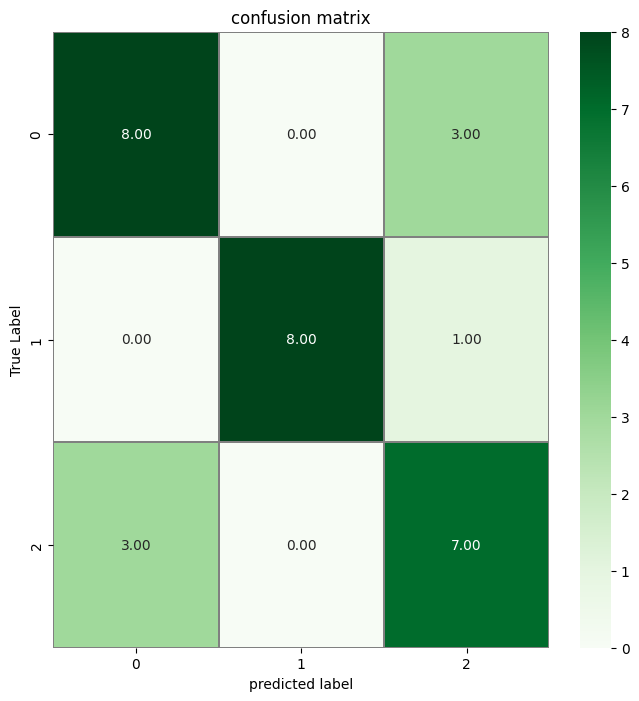

In [35]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [36]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

      Lesion       0.73      0.73      0.73        11
    Melanoma       1.00      0.89      0.94         9
   Psoriasis       0.64      0.70      0.67        10

    accuracy                           0.77        30
   macro avg       0.79      0.77      0.78        30
weighted avg       0.78      0.77      0.77        30



# Transfer Learning with VGG_16 pre-trained CNN model

### Fine tuning VGG16 pre-trained model
Using Transfer Learning with advanced and popular VGG16 architecture with pre-trained weights on the popular ImageNet dataset. Then adapt it to our dataset. So, it will be our base Model

In [37]:
# load the VGG16 model without the final layers(include_top=False)
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=X_train.shape[1:])
print("Base Model loaded !")
 
"""
  Loop over all layers in the base model and freeze them so they will
  not be updated during the first training process
"""
for layer in baseModel.layers:
    layer.trainable = False
    
baseModel.summary()

58889256/58889256 [==============================] - 0s 0us/step
Base Model loaded !
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                          

In [38]:
# In the summary above of our base model, trainable params is 0
""" Now, let's create a headModel to put on top of the base model
    (we are not freezing any layers of this model) 
"""
headModel = Sequential()
headModel.add(AveragePooling2D(pool_size=(4,4), input_shape=baseModel.output_shape[1:], name="AveragePooling2"))
headModel.add(Flatten( name ="Flatten"))
headModel.add(Dense(64, activation ="relu"))
headModel.add(Dropout(0.5, name="Dropout"))
headModel.add(Dense(no_of_classes, activation="softmax"))

headModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 AveragePooling2 (AveragePoo  (None, 1, 1, 512)        0         
 ling2D)                                                         
                                                                 
 Flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 33,027
Trainable params: 33,027
Non-trainable params: 0
__________________________________________________

### Final Model
Here we are just going to put each model in its place, Yeah! We are talking about the base model (baseModel) and the head model (headModel). Therefor, we will put the first on the base and the second on the top. So, our final will look as showen below :

In [39]:
# In the summary above of our base model, trainable params is 32, 962
""" Let's build the final model where we add the top_model on top of base_model.
    So, we will place the head Model on the top of the base Model. Therefore, this 
    'Model' will become the actual model we will train
"""
Model = Sequential()
Model.add(baseModel)
Model.add(headModel)
 
# I can check the summary of the final Model which we created by using the line of code below.
Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 sequential_2 (Sequential)   (None, 3)                 33027     
                                                                 
Total params: 14,747,715
Trainable params: 33,027
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:
lr = 1e-3
epochs = 50
bs = 8
optimizer = Adam(lr = lr, decay= lr/epochs)
Model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


---

### **Modelling**

In [41]:
# Time to train our model !
epochs = 100
 
# Initialize the training data augmentation object
train_datagen = ImageDataGenerator(
        rotation_range=15,
        fill_mode ="nearest")
 
checkpointer = ModelCheckpoint(filepath = "/content/drive/My Drive/best.h5", save_best_only = True, verbose=1)
start = time.time()
 
# let's get started !
 
history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),
                            steps_per_epoch = len(X_train)//bs,
                            validation_data = (X_valid, y_valid),
                            validation_steps = len(X_valid)//bs,
                            epochs =epochs,
                            callbacks= [checkpointer])
 
end = time.time()
duration = end - start
print ('\n This Model took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs) )

Epoch 1/100


<ipython-input-41-e525926cc2c0>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=Model.fit_generator(train_datagen.flow(X_train, y_train, batch_size = bs),


30/30 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.3500
Epoch 1: val_loss improved from inf to 0.61537, saving model to /content/drive/My Drive/best.h5
30/30 [==============================] - 7s 188ms/step - loss: 0.6968 - accuracy: 0.3500 - val_loss: 0.6154 - val_accuracy: 0.5667
Epoch 2/100
29/30 [============================>.] - ETA: 0s - loss: 0.6161 - accuracy: 0.4698
Epoch 2: val_loss improved from 0.61537 to 0.61009, saving model to /content/drive/My Drive/best.h5
30/30 [==============================] - 2s 57ms/step - loss: 0.6141 - accuracy: 0.4792 - val_loss: 0.6101 - val_accuracy: 0.4667
Epoch 3/100
30/30 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.5542
Epoch 3: val_loss improved from 0.61009 to 0.59136, saving model to /content/drive/My Drive/best.h5
30/30 [==============================] - 2s 63ms/step - loss: 0.5863 - accuracy: 0.5542 - val_loss: 0.5914 - val_accuracy: 0.4667
Epoch 4/100
30/30 [=====================

In [42]:
(eval_loss, eval_accuracy) = Model.evaluate(  
     X_test, y_test, batch_size=bs, verbose=2)
 
print("Accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("Loss: {}".format(eval_loss))

4/4 - 1s - loss: 0.1504 - accuracy: 0.9000 - 1s/epoch - 272ms/step
Accuracy: 90.00%
Loss: 0.15041758120059967


### **Evaluation**

### Accuracy and Loss graphs

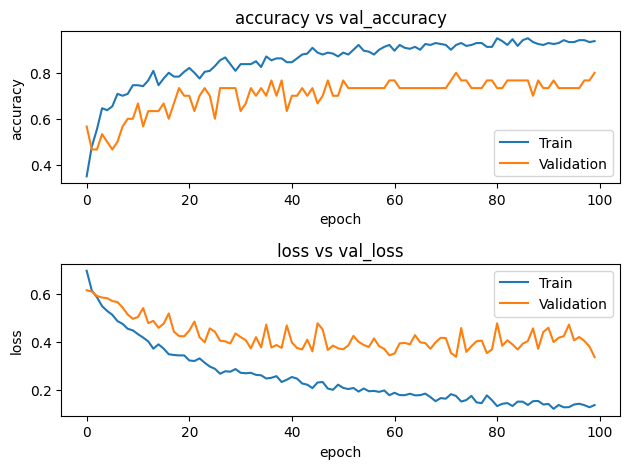

In [43]:
# Let's visualize the train/validation loss and accuracy wrt epochs
 
import matplotlib.pyplot as plt 
def plot(history):
    plt.figure(1) 
     # Summarize history for accuracy  
 
    plt.subplot(211)  
    plt.plot(history.history['accuracy'])  
    plt.plot(history.history['val_accuracy'])  
    plt.title('accuracy vs val_accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='lower right')  
 
     # Summarize history for loss  
 
    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('loss vs val_loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()
 
# Finaly, let's call the plot function with the 'result' parameter 
 
plot(history)

### **Prediction**
Testing our model against more random samples from the test data !

1/1 [==============================] - 3s 3s/step


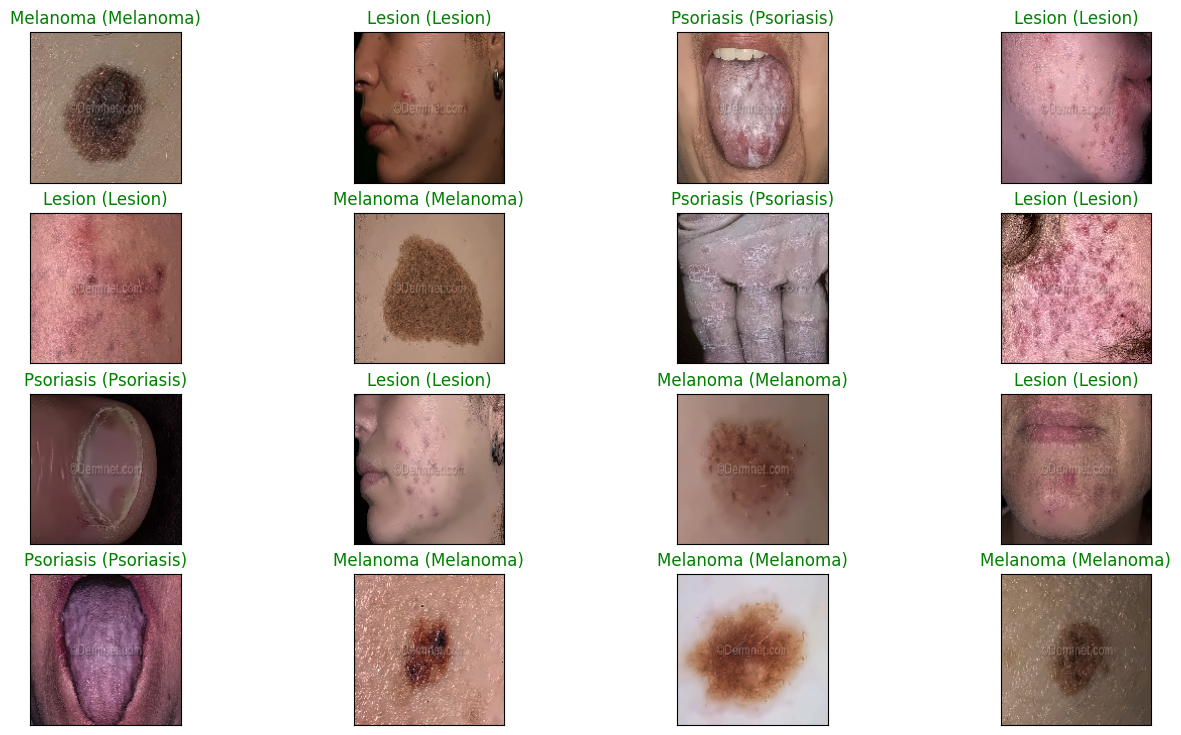

In [44]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# Plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))
 
visualize_pred(Model.predict(X_test))

### Confusion Matrix

1/1 [==============================] - 0s 23ms/step


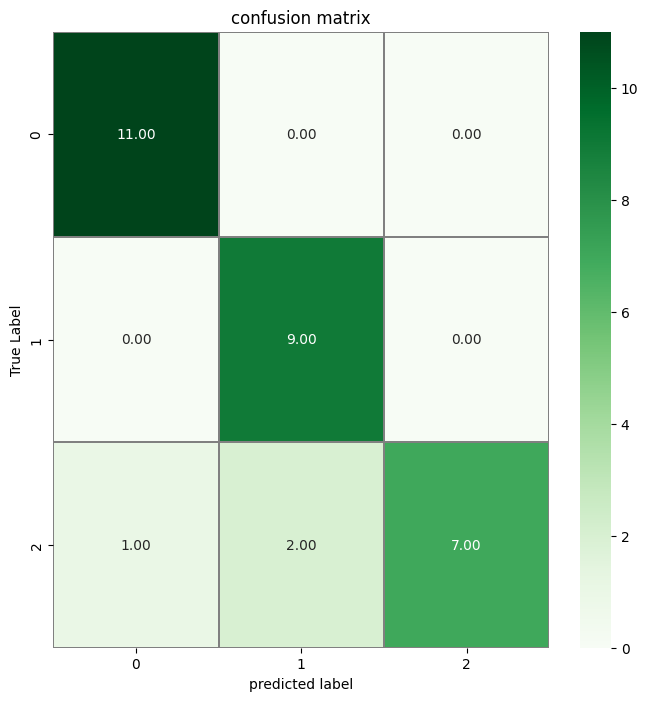

In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = Model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

In [46]:
print(classification_report(y_test.argmax(axis=1),Y_pred_classes,  target_names= labels))

              precision    recall  f1-score   support

      Lesion       0.92      1.00      0.96        11
    Melanoma       0.82      1.00      0.90         9
   Psoriasis       1.00      0.70      0.82        10

    accuracy                           0.90        30
   macro avg       0.91      0.90      0.89        30
weighted avg       0.91      0.90      0.90        30



# **Some Prediction on Test dataset**

1/1 [==============================] - 0s 25ms/step


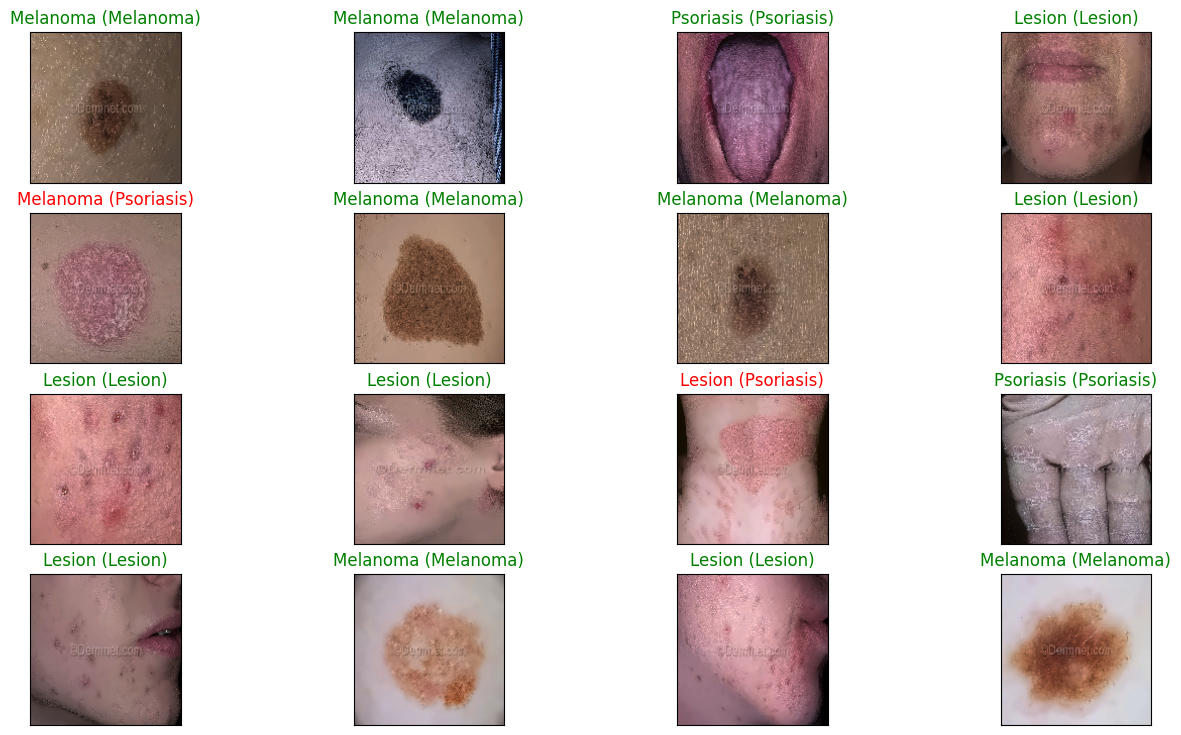

In [47]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(Model.predict(X_test))

# **Making Some Recognition**

In [48]:
def Get_Prediction(path):
    global Model
    arr = []
    img_width, img_height = 150,150 
    img = load_img(path, target_size = (img_width, img_height))
    img=np.uint8(img)
    img = cv2.fastNlMeansDenoisingColored(img)
    arr.append(img)
    np_img = np.array(arr)
    scaled_img = np_img.astype('float32')/255
    result = Model.predict(scaled_img)
    pred_idx = np.argmax(result)
    prediction =labels[pred_idx]
    proba = round(np.amax(result),2)
    print("The result of recognition is", prediction, "With probability", proba,"%")

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# **Psoriasis**

1/1 [==============================] - 0s 499ms/step
The result of recognition is Psoriasis With probability 1.0 %


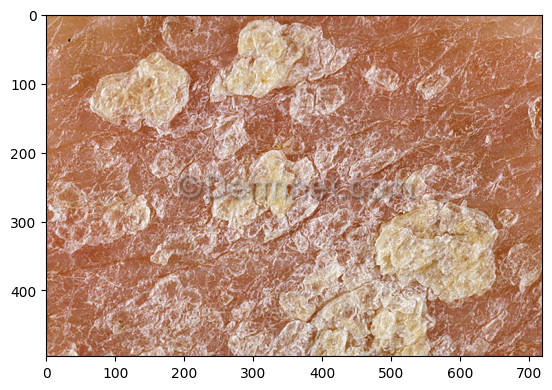

In [50]:
path = "/content/drive/My Drive/image3.jpg"


img=mpimg.imread(path)
imgplot = plt.imshow(img)

Get_Prediction(path)

# **Melanoma**

1/1 [==============================] - 0s 19ms/step
The result of recognition is Melanoma With probability 1.0 %


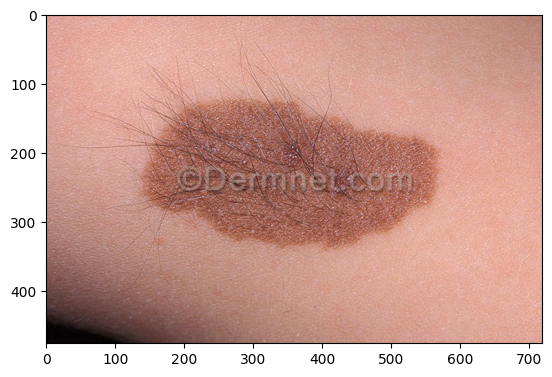

In [51]:
path = "/content/drive/My Drive/image2.jpg"

img=mpimg.imread(path)
imgplot = plt.imshow(img)

Get_Prediction(path)

# **Lesion**

1/1 [==============================] - 0s 19ms/step
The result of recognition is Lesion With probability 0.99 %


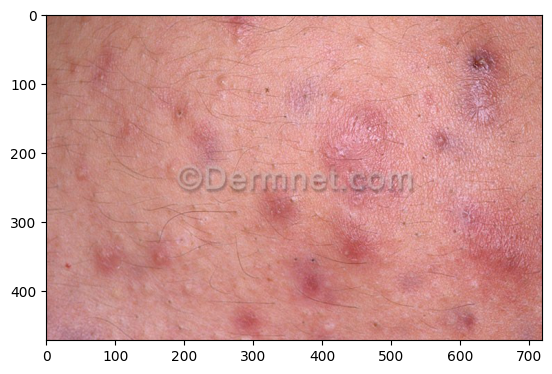

In [52]:
path = "/content/drive/My Drive/image1.jpg"

img=mpimg.imread(path)
imgplot = plt.imshow(img)

Get_Prediction(path)

# **Congrats! We have a rubost model!**